In [1]:
import surprise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm.auto import tqdm
from surprise import BaselineOnly, Dataset, Reader, SVD, accuracy
from collections import defaultdict

sns.set_style("whitegrid")

In [2]:
df_plantnet = pd.read_parquet("./data/recsys_interactions_minimal.parquet")
df_plantnet.head()

,obs_id,item_id,user_id,user_weight,interaction_type,value,obs_author,number_of_items,AI_determination_1,AI_score_1,...,observation_time,observation_year,observation_month,interaction_time_gap,user_determination_family,user_determination_genus,AI_determination_1_family,AI_determination_1_genus,AI_determination_2_family,AI_determination_2_genus
index,,,,,,,,,,,,,,,,,,,,,
1096,1001018503,None,100256658,9.81,determination,None,100484701,2,Cuphea micropetala Kunth,0.54508,...,1510175067000,2017,11,0,None,None,Lythraceae,Cuphea,Campanulaceae,Lobelia
1097,1001018503,50cab54f2ea7ccf60c54263423bb2bf1307a4ba7,100256658,9.81,quality,False,100484701,2,Cuphea micropetala Kunth,0.54508,...,1510175067000,2017,11,0,None,None,Lythraceae,Cuphea,Campanulaceae,Lobelia
1098,1001018503,50cab54f2ea7ccf60c54263423bb2bf1307a4ba7,100385054,0.74,quality,False,100484701,2,Cuphea micropetala Kunth,0.54508,...,1510175067000,2017,11,0,None,None,Lythraceae,Cuphea,Campanulaceae,Lobelia
1099,1001018503,50cab54f2ea7ccf60c54263423bb2bf1307a4ba7,100465488,11.44,noplant,None,100484701,2,Cuphea micropetala Kunth,0.54508,...,1510175067000,2017,11,0,None,None,Lythraceae,Cuphea,Campanulaceae,Lobelia
1100,1001018503,None,100484701,4.00,determination,Lobelia laxiflora Kunth,100484701,2,Cuphea micropetala Kunth,0.54508,...,1510175067000,2017,11,632,Campanulaceae,Lobelia,Lythraceae,Cuphea,Campanulaceae,Lobelia


The goal here is to use the family of the AI to generate recommendations

In [69]:
def preprocess_plantnet_data(
    logs_path,
    min_number_of_reviews=50,
    min_number_of_participations=10,
    use_genera=True, # else uses families
):
    print("Preparing ratings log")
    logs = pd.read_parquet(logs_path)
    keyword = "AI_determination_1_genus" if use_genera else "AI_determination_1_family"
    obs_counts = logs[keyword].value_counts()
    obs_to_keep = (
        pd.DataFrame(obs_counts)
        .loc[pd.DataFrame(obs_counts)["count"] >= min_number_of_reviews]
        .index
    )
    logs = logs.loc[logs[keyword].isin(obs_to_keep)]
    logs["rating"] = logs["interaction_type"].map(
        {"determination": 1, "quality": 0, "noplant": 0, "organ": 0, "malformed": 0}
    )
    logs = (
        logs[["user_id", keyword, "rating"]]
        .groupby(["user_id", keyword])
        .sum()
        .reset_index()
    )
    interactions_count = logs["user_id"].value_counts()
    user_to_keep = (
        pd.DataFrame(interactions_count)
        .loc[pd.DataFrame(interactions_count)["count"] >= min_number_of_participations]
        .index
    )
    logs = logs.loc[logs["user_id"].isin(user_to_keep)]

    logs = logs.sample(frac=1)
    logs["t"] = np.arange(len(logs))
    logs.index = logs["t"]
    print(
        f"""
    Keeping: {logs[keyword].nunique()} {keyword} and {logs["user_id"].nunique()} user with a total of {logs.shape} interations
"""
    )
    le_user = preprocessing.LabelEncoder()
    le_item = preprocessing.LabelEncoder()
    logs["user_id"] = le_user.fit_transform(logs["user_id"])
    logs[keyword] = le_item.fit_transform(logs[keyword])
    return logs, le_user, le_item

In [71]:
use_genera = True
keyword = "AI_determination_1_genus" if use_genera else "AI_determination_1_family"

logs, le_user, le_item = preprocess_plantnet_data(
    "./data/recsys_interactions_minimal.parquet",
    min_number_of_reviews=10,
    min_number_of_participations=20,
    use_genera=use_genera
)
logs.drop("t", inplace=True, axis=1)
logs.columns = ["user_id", "item_id", "response"]
logs["response"] = logs["response"] > 0
logs.head()

Preparing ratings log

    Keeping: 1811 AI_determination_1_genus and 4856 user with a total of (329874, 4) interations



,user_id,item_id,response
t,,,
0,2118,993,True
1,3284,242,True
2,2101,394,True
3,3003,1783,True
4,2325,1297,True


We also need the records for each observation / user kept determination

In [72]:
df_plantnet = df_plantnet[df_plantnet[keyword].isin(le_item.classes_)]
df_plantnet = df_plantnet[df_plantnet["user_id"].isin(le_user.classes_)]
df_plantnet = df_plantnet[df_plantnet["interaction_type"] == "determination"]
df_plantnet.head()

,obs_id,item_id,user_id,user_weight,interaction_type,value,obs_author,number_of_items,AI_determination_1,AI_score_1,...,observation_time,observation_year,observation_month,interaction_time_gap,user_determination_family,user_determination_genus,AI_determination_1_family,AI_determination_1_genus,AI_determination_2_family,AI_determination_2_genus
index,,,,,,,,,,,,,,,,,,,,,
1267,1005188264,None,101445260,12.26,determination,None,101477745,1,Citrus limon (L.) Burm.f.,0.29117,...,1573218504935,2019,11,0,None,None,Rutaceae,Citrus,Celastraceae,Euonymus
8591,1002520557,None,101458154,15.87,determination,None,100656323,1,Camellia japonica L.,0.24942,...,1532466441000,2018,7,444,None,None,Theaceae,Camellia,Rosaceae,Rosa
8876,1003921502,None,100730943,16.67,determination,None,100958448,1,Crassula ovata E.Mey. ex Harv. & Sond.,0.38907,...,1558821412237,2019,5,165,None,None,Crassulaceae,Crassula,Asteraceae,Limbarda
8886,1005029911,None,100730943,16.67,determination,None,100598861,1,Crassula ovata E.Mey. ex Harv. & Sond.,0.66351,...,1570300762556,2019,10,33,None,None,Crassulaceae,Crassula,Aizoaceae,Disphyma
11194,1009671685,None,101458154,15.87,determination,None,102873009,1,Cucurbita pepo L.,0.23162,...,1614955267918,2021,3,850,None,None,Cucurbitaceae,Cucurbita,Cucurbitaceae,Citrullus


In [75]:
def stratified_split(data, test_size=0.2):
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Perform stratified split by user
    for user_id, user_data in data.groupby("user_id"):
        user_train, user_test = train_test_split(
            user_data, test_size=test_size, random_state=42
        )
        train_data = pd.concat([train_data, user_train])
        test_data = pd.concat([test_data, user_test])

    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)


train_log, test_log = stratified_split(logs)

from mab2rec.utils import print_interaction_stats

print_interaction_stats(train_log)
print_interaction_stats(test_log)

reader = Reader(rating_scale=(0, 1))

train_log.columns = ["userID", "itemID", "rating"]
test_log.columns = ["userID", "itemID", "rating"]

userRatings_data_train = Dataset.load_from_df(train_log, reader).build_full_trainset()
algo = SVD(biased=False)
algo.fit(userRatings_data_train)
features_users_svd = algo.pu
features_items_svd = algo.qi

Number of rows: 261,995
Number of users: 4,856
Number of items: 1,803
Mean response rate: 0.9500

Number of rows: 67,879
Number of users: 4,856
Number of items: 1,653
Mean response rate: 0.9519



Save everything to csv format

In [66]:
features_users_svd = np.hstack(
    (np.arange(features_users_svd.shape[0]).reshape(-1, 1), features_users_svd))
train_log.columns = ["user_id", "item_id" ,"response"]
test_log.columns = ["user_id", "item_id", "response"]

In [67]:
features_users_svd = pd.DataFrame(features_users_svd)
features_users_svd = features_users_svd.rename(columns={0: "user_id"})
features_users_svd.to_csv("./simulated_data/user_features_plantnet.csv", index=False)
train_log.to_csv("./simulated_data/train_log_plantnet.csv", index=False)
test_log.to_csv("./simulated_data/test_log_plantnet.csv", index=False)
features_users_svd.head()

,user_id,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.0,0.223352,0.301377,0.134819,0.007108,0.105576,-0.216178,-0.138300,0.005484,-0.074147,...,-0.170961,0.009595,-0.153124,0.125818,0.012002,-0.006392,-0.174077,0.016589,-0.068909,-0.078080
1,1.0,0.164473,0.277950,0.176180,0.004672,0.145782,-0.059033,-0.065897,0.094464,-0.037459,...,-0.050514,0.103917,-0.097803,0.110351,-0.050090,0.095493,-0.091894,0.113430,-0.235197,-0.013188
2,2.0,0.171045,0.222277,0.107827,0.078445,0.221464,-0.151604,-0.105996,0.059637,-0.103868,...,-0.232050,0.014128,-0.111372,-0.092694,-0.164949,-0.012834,-0.027120,0.098167,-0.106907,-0.075645
3,3.0,0.019481,0.312415,0.244894,0.008833,0.157942,-0.163594,-0.234283,0.091936,0.201672,...,-0.109661,-0.327564,-0.034659,0.072995,-0.163752,-0.020802,-0.197229,0.192043,-0.159292,-0.014949
4,4.0,-0.071629,0.264935,0.052252,0.045697,0.072841,-0.161931,-0.036592,-0.129301,-0.101220,...,-0.120158,0.022901,-0.146237,0.067074,-0.041803,0.024003,-0.054785,0.046184,-0.110205,-0.084034


## Run recsys without aggregation constraints

In [54]:
rating_df = pd.concat([train_log, test_log])
rating_df

,user_id,item_id,response
0,0,175,True
1,0,189,True
2,0,86,True
3,0,116,True
4,0,96,True
...,...,...,...
4859,186,29,True
4860,186,90,True
4861,186,44,True
4862,186,207,True


In [55]:
class linucb_disjoint_arm:

    def __init__(self, arm_index, d, alpha):
        self.arm_index = arm_index
        self.alpha = alpha
        self.A = np.identity(d)
        self.b = np.zeros([d, 1])

    def calc_UCB(self, x_array):
        A_inv = np.linalg.inv(self.A)
        self.theta = np.dot(A_inv, self.b)
        x = x_array.reshape([-1, 1])
        p = np.dot(self.theta.T, x) + self.alpha * np.sqrt(
            np.dot(x.T, np.dot(A_inv, x))
        )
        return p

    def reward_update(self, reward, x_array):
        x = x_array.reshape([-1, 1])
        self.A += np.dot(x, x.T)
        self.b += reward * x

class linucb_policy():

    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]

    def select_arm(self, x_array):
        highest_ucb = -1
        candidate_arms = []

        for arm_index in range(self.K_arms):
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            if arm_ucb > highest_ucb:
                highest_ucb = arm_ucb
                candidate_arms = [arm_index]

            if arm_ucb == highest_ucb:
                candidate_arms.append(arm_index)
        chosen_arm = np.random.choice(candidate_arms)
        return chosen_arm


In [56]:
def ctr_simulator(K_arms, d, alpha, user_features):
    linucb_policy_object = linucb_policy(K_arms=K_arms, d=d, alpha=alpha)
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    for row in tqdm(rating_df.values, total=len(rating_df)):
        user, item, rating = row
        data_arm = row[1]
        data_reward = row[2]
        data_x_array = user_features[user]

        arm_index = linucb_policy_object.select_arm(data_x_array)

        if arm_index + 1 == data_arm:
            linucb_policy_object.linucb_arms[arm_index].reward_update(
                    data_reward, data_x_array
                )
            aligned_time_steps += 1
            cumulative_rewards += data_reward
            aligned_ctr.append(cumulative_rewards / aligned_time_steps)
    return (aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object)

In [57]:
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(
    K_arms=rating_df["item_id"].nunique(),
    d=features_users_svd.shape[1],
    alpha=1.0,
    user_features=features_users_svd.values[:, 1:],
)

  0%|          | 0/23929 [00:00<?, ?it/s]

Text(0.5, 1.0, 'alpha = 1')

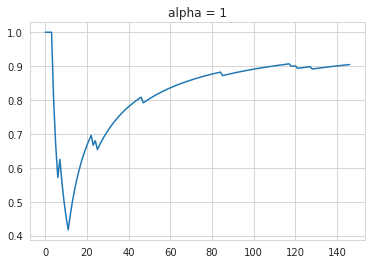

In [58]:
plt.plot(aligned_ctr)
plt.title("alpha = 1")

## Run 2

In [58]:
rating_df = pd.concat([train_log, test_log])
rating_df

,user_id,item_id,response
0,0,828,True
1,0,48,True
2,0,846,True
3,0,1513,True
4,0,345,True
...,...,...,...
35411,706,761,True
35412,706,305,True
35413,706,1246,True
35414,706,828,True


In [59]:
from tqdm.auto import tqdm


class ReplaySimulator:
    def __init__(
        self,
        n_visits,
        reward_history,
        item_col_name,
        visitor_col_name,
        reward_col_name,
        n_iterations=1,
        random_seed=1,
    ):
        np.random.seed(random_seed)
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name
        self.n_visits = n_visits
        self.n_iterations = n_iterations
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)

    def reset(self):
        self.n_item_samples = np.zeros(self.n_items)
        self.n_item_rewards = np.zeros(self.n_items)

    def replay(self):
        results = []
        for iteration in tqdm(range(self.n_iterations), total=self.n_iterations):
            self.reset()
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in tqdm(
                range(self.n_visits), desc="Visits", total=self.n_visits, leave=False
            ):
                found_match = False
                while not found_match:
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    reward = self.reward_history.query(
                        f"{self.item_col_name} == @item_id and {self.visitor_col_name} == @visitor_id"
                    )[self.reward_col_name]
                    found_match = reward.shape[0] > 0

                reward_value = reward.iloc[0]
                self.record_result(visit, item_idx, reward_value)
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards / (visit + 1)
                results.append(
                    {
                        "iteration": iteration,
                        "visit": visit,
                        "item_id": item_id,
                        "visitor_id": visitor_id,
                        "reward": reward_value,
                        "total_reward": total_rewards,
                        "fraction_relevant": fraction_relevant[visit],
                    }
                )
        return results

    def select_item(self):
        return np.random.randint(self.n_items)

    def record_result(self, visit, item_idx, reward):
        self.n_item_samples[item_idx] += 1
        alpha = 1.0 / self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (
            reward - self.n_item_rewards[item_idx]
        )

In [60]:
class RandomReplayer(ReplaySimulator):
    def __init__(
        self,
        n_visits,
        reward_history,
        item_col_name,
        visitor_col_name,
        reward_col_name,
        n_iterations=1,
    ):
        super(RandomReplayer, self).__init__(
            n_visits,
            reward_history,
            item_col_name,
            visitor_col_name,
            reward_col_name,
            n_iterations,
        )

    def select_item(self):
        return np.random.choice(len(self.n_item_rewards))

In [61]:
class EpsilonGreedyReplayer(ReplaySimulator):
    def __init__(
        self,
        epsilon,
        n_visits,
        reward_history,
        item_col_name,
        visitor_col_name,
        reward_col_name,
        n_iterations=1,
    ):
        super(EpsilonGreedyReplayer, self).__init__(
            n_visits,
            reward_history,
            item_col_name,
            visitor_col_name,
            reward_col_name,
            n_iterations,
        )
        self.epsilon = epsilon

    def select_item(self):
        if np.random.uniform() < self.epsilon:  # explore
            item_id = super(EpsilonGreedyReplayer, self).select_item()
        else:
            item_id = np.argmax(self.n_item_rewards)
        return item_id

In [62]:
class ThompsonSamplingReplayer(ReplaySimulator):
    def reset(self):
        self.alphas = np.ones(self.n_items)
        self.betas = np.ones(self.n_items)

    def select_item(self):
        samples = [np.random.beta(a, b) for a, b in zip(self.alphas, self.betas)]
        return np.argmax(samples)

    def record_result(self, visit, item_idx, reward):
        if reward == 1:
            self.alphas[item_idx] += 1
        else:
            self.betas[item_idx] += 1

In [63]:
n_visits = 10000
n_iterations = 5

reward_history = rating_df
item_col_name = "item_id"
visitor_col_name = "user_id"
reward_col_name = "response"

epsilon = 0.05
epsilon_005_results = EpsilonGreedyReplayer(
    epsilon,
    n_visits,
    reward_history,
    item_col_name,
    visitor_col_name,
    reward_col_name,
    n_iterations=n_iterations,
).replay()
epsilon_005_results_df = pd.DataFrame(epsilon_005_results)
epsilon_005_results_df.head()

epsilon = 0.1
epsilon_01_results = EpsilonGreedyReplayer(
    epsilon,
    n_visits,
    reward_history,
    item_col_name,
    visitor_col_name,
    reward_col_name,
    n_iterations=n_iterations,
).replay()

epsilon_01_results_df = pd.DataFrame(epsilon_01_results)
epsilon_01_results_df.head()
random_results = RandomReplayer(
    n_visits,
    reward_history,
    item_col_name,
    visitor_col_name,
    reward_col_name,
    n_iterations=n_iterations,
).replay()

random_df = pd.DataFrame(random_results)
random_df.head()

ts_replayer = ThompsonSamplingReplayer(
    n_visits,
    reward_history,
    item_col_name,
    visitor_col_name,
    reward_col_name,
    n_iterations=n_iterations,
).replay()

ts_df = pd.DataFrame(ts_replayer)
ts_df.head()

  0%|          | 0/5 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,871,72,True,1,1.000000
1,0,1,6,200,True,2,1.000000
2,0,2,1040,491,False,2,0.666667
3,0,3,119,657,True,3,0.750000
4,0,4,329,151,True,4,0.800000


In [64]:
epsilon_005_avg_results_df = epsilon_005_results_df.groupby(
    "visit", as_index=False
).mean()
epsilon_01_avg_results_df = epsilon_01_results_df.groupby(
    "visit", as_index=False
).mean()
random_avg_results = random_df.groupby("visit", as_index=False).mean()
ts_avg_results = ts_df.groupby("visit", as_index=False).mean()

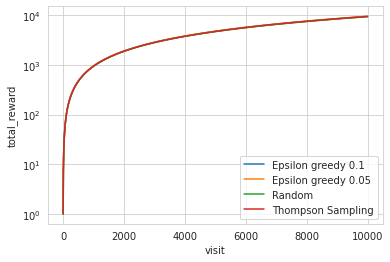

In [72]:
fig, ax = plt.subplots()
sns.lineplot(
    data=epsilon_01_avg_results_df,
    x="visit",
    y="total_reward",
    label="Epsilon greedy 0.1",
    ax=ax,
)
sns.lineplot(
    data=epsilon_005_avg_results_df,
    x="visit",
    y="total_reward",
    label="Epsilon greedy 0.05",
    ax=ax,
)
sns.lineplot(
    data=random_avg_results,
    x="visit",
    y="total_reward",
    label="Random",
    ax=ax,
)
sns.lineplot(
    data=ts_avg_results,
    x="visit",
    y="total_reward",
    label="Thompson Sampling",
    ax=ax,
)
ax.set_yscale("log")

With MAB2rec

In [36]:
from jurity.recommenders import BinaryRecoMetrics, RankingRecoMetrics

# Column names for the response, user, and item id columns
metric_params = {
    "click_column": "score",
    "user_id_column": "user_id",
    "item_id_column": "item_id",
}

# Evaluate peformance at different k-recommendations
top_k_list = [3, 5, 10]

# List of metrics to benchmark
metrics = []
for k in top_k_list:
    metrics.append(BinaryRecoMetrics.AUC(**metric_params, k=k))
    metrics.append(BinaryRecoMetrics.CTR(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.Precision(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.Recall(**metric_params, k=k))


In [39]:
from mab2rec.pipeline import benchmark
from mab2rec import BanditRecommender, LearningPolicy, NeighborhoodPolicy

recommenders = {
    "Random": BanditRecommender(learning_policy=LearningPolicy.Random()),
    "LinGreedy": BanditRecommender(
        learning_policy=LearningPolicy.LinGreedy(epsilon=0.1)
    ),
    "LinTS": BanditRecommender(learning_policy=LearningPolicy.LinTS()),
    "ClustersTS": BanditRecommender(
        learning_policy=LearningPolicy.ThompsonSampling(),
        neighborhood_policy=NeighborhoodPolicy.Clusters(n_clusters=10),
    ),
}
reco_to_results, reco_to_metrics = benchmark(
    recommenders,
    metrics=metrics,
    train_data="./simulated_data/train_log_plantnet.csv",
    test_data="./simulated_data/test_log_plantnet.csv",
    user_features="./simulated_data/user_features_plantnet.csv",
)

/home/tlefort/condaenvs/phd/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/tlefort/condaenvs/phd/lib/python3.9/site-packages/jurity/recommenders/precision.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged = merged.fillna(False)
/home/tlefort/condaenvs/phd/lib/python3.9/site-packages/jurity/recommenders/precision.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mer

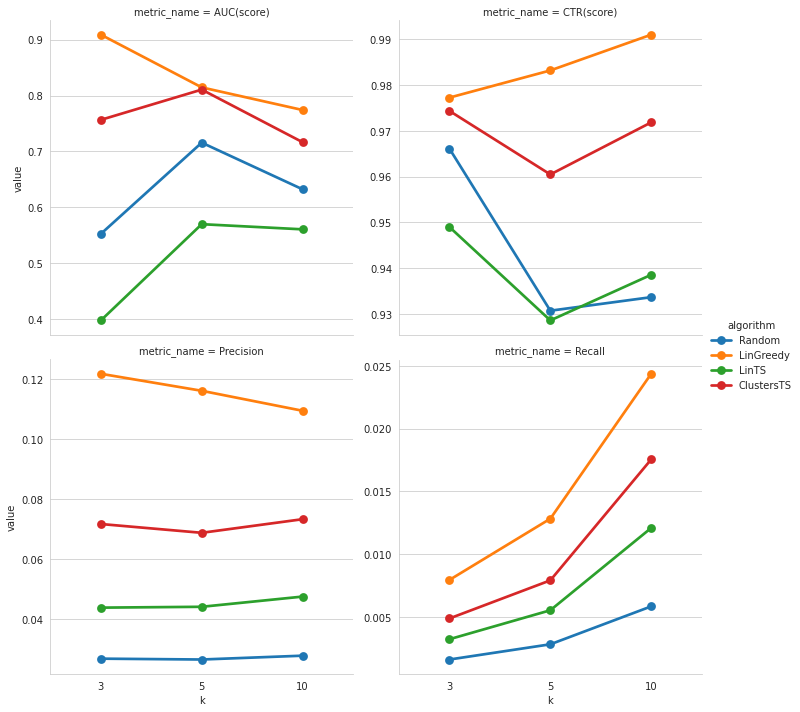

In [40]:
from mab2rec.visualization import plot_metrics_at_k
plot_metrics_at_k(reco_to_metrics, col_wrap=2)

In [45]:
recommenders["LinGreedy"].mab._imp.__dict__.keys()

dict_keys(['rng', 'arms', 'n_jobs', 'backend', 'arm_to_expectation', 'arm_to_status', 'alpha', 'epsilon', 'l2_lambda', 'regression', 'scale', 'num_features', 'arm_to_model'])

In [68]:
from mab2rec.utils import print_interaction_stats
print_interaction_stats(train_log)

Number of rows: 140,262
Number of users: 707
Number of items: 1,577
Mean response rate: 0.9431

